# REGULATING CELL CYCLE IN XENPUS LAEVIS

In [1]:
from controlSBML import ControlSBML
import control
import numpy as np

# 1. Problem Description

This is a multiple output model that describes interactions regulating cell cycle in Xenpus laevis. The phosphorolation of CyclinB1Cdk1 complexes is a necessary precursor to mitosis. This phosphorylation is regulated by three key interacting proteins (see [figure 1](https://journals.plos.org/plosbiology/article/figure/image?download&size=original&id=10.1371/journal.pbio.1001788.g001) in [accompanying publication](https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.1001788)). The regulatory dynamics are described in [this ODE model](https://www.ebi.ac.uk/biomodels/BIOMD0000000719#Overview). Repressing the peak of phosphorolated CyclinB1Cdk1 oscillations could delay or inhibit cell cycle progression.

To repress phosphorolated CyclinB1Cdk1 oscillations, I will try to regulate APC_C. APC_C, which is activated by Plx_1_active, targets Cyclin for degradation by the proteasome.


# 2. Control Objectives

To try to repress or slow the progression of the cell cycle, my control objective is to maintain APC_C_active concentration of .75. The range of possible APC_C_active concentrations is from 0 to 1, so maintaining above .5 is keeping the concentration relatively high.

There are five species in this model:
1. Cyclin_B1_Cdk1_complex_phosphorylated which I will not manipulate or track 
2. Cyclin_B1_Cdk1_complex_unphosphorylated which I will not manipulate or track 
3. Plx1_active which I will manipulate as my control input
4. APC_C_active which I will aim to control with Plx1_active
5. APC_C_total which I will not manipulate or track

### System Definition

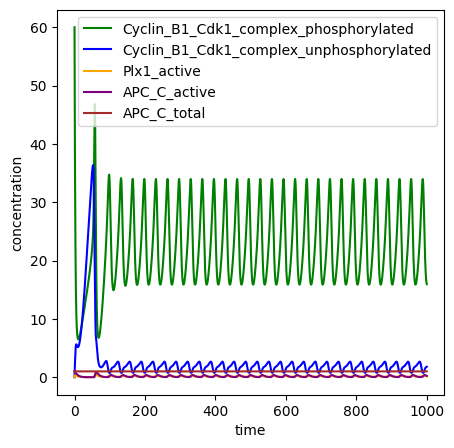

In [2]:
URL = "https://www.ebi.ac.uk/biomodels/services/download/get-files/MODEL1809060006/5/Tsai2014.xml"
CTLSB = ControlSBML(URL, times=np.linspace(0, 1000, 10000))
_ = CTLSB.plotModel(legend=True)

In [3]:
antimony_model = CTLSB.getAntimony()
print(antimony_model)

// Created by libAntimony v2.13.2
function Constant_flux__irreversible(v)
  v;
end

Constant_flux__irreversible is "Constant flux (irreversible)"

function function_for_cdk1a_degradation_by_apc_2(APC_C_active, Cyclin_B1_Cdk1_complex_phosphorylated, k_dest)
  k_dest*APC_C_active*Cyclin_B1_Cdk1_complex_phosphorylated;
end

function_for_cdk1a_degradation_by_apc_2 is "function for cdk1a degradation by apc_2"

function function_for_apc_activation_1(APC_C_active, APC_C_total, Plx1_active, ec50_apc, k_apc_on, n_apc)
  (k_apc_on/(1 + (ec50_apc/Plx1_active)^n_apc))*(APC_C_total - APC_C_active);
end

function_for_apc_activation_1 is "function for apc activation_1"

function function_for_cdk1a_degradation_by_apc_1(APC_C_active, Cyclin_B1_Cdk1_complex_unphosphorylated, k_dest)
  k_dest*APC_C_active*Cyclin_B1_Cdk1_complex_unphosphorylated;
end

function_for_cdk1a_degradation_by_apc_1 is "function for cdk1a degradation by apc_1"

function function_for_plx1_activation_1(Cyclin_B1_Cdk1_complex_phospho

### Control Objective 1: Maintain APC_C_active concentration above .5 by manipulating Plx1_active 

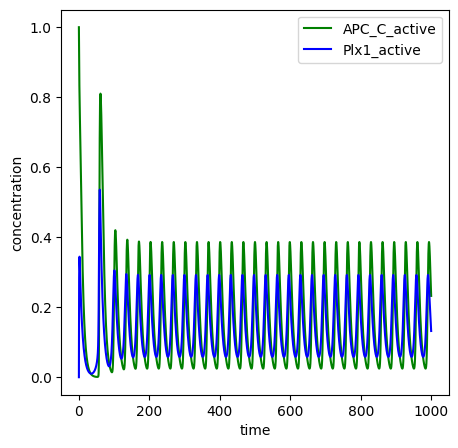

In [4]:
_ = CTLSB.plotModel(legend=True, selections=["Plx1_active", "APC_C_active"])

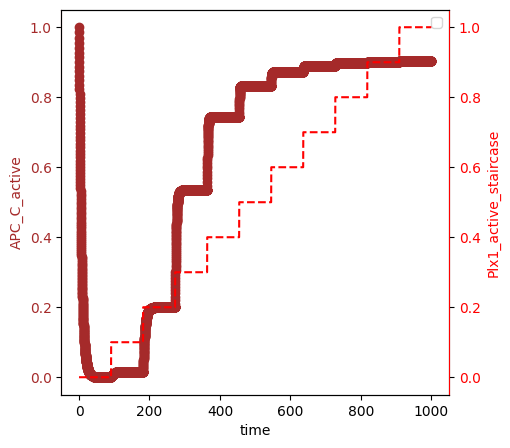

In [5]:
CTLSB.setSystem(input_name="Plx1_active", output_name="APC_C_active")
_ = CTLSB.plotStaircaseResponse(final_value=1, num_step=10)

Increasing Plx1_active increases APC_C_active to an extent, but the concentration of APC_C_active reaches a maximum value around .9. However, the response is nonlinear. This means the reasonable range of outputs os between 0 and .9 with the corresponding range of inputs from 0 to 1. All concentrations in this model are roughly nM, so these ranges seem biologically plausable. They are also well within the range of values seen in the plot of the overall SMBL model.

It looks like APC_C_active concentrations can be kept above .5 if Plx1_active concentrations are held steady between .4 and 1. 

## System identification summary

SMBL Model: This model represents the dynamics associated with cell cycle regulation in Xenopus lavis. It can be found [online at this link](https://www.ebi.ac.uk/biomodels/BIOMD0000000719#Overview), and it was published alongside [this article](https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.1001788). 

Output: APC_C_active for both control objectives.

Input: Plx1_active for both control objectives.

Directional effect of input on output: Increasing Plx1_active increases APC_C_active to an extent, but the concentration of APC_C_active reaches a maximum value around .9. 

Operating region for the input: the input operating range is from 0 to 1

Feasible Setpoints:The feasible setpoints are from 0 to .9


# 3. System Identification
Here I try to fit a transfer function that describes the relationship between the input ``Plx1_active`` and the output ``APC_C_active``. I will report the $R^2$ values. Also, I will fit the transfer function starting at time 200 to avoid the transient from initial values in the simulation.

To address this issue I have to set title to an empty string. Thus, unfortunately the following plots do not have informative titles.

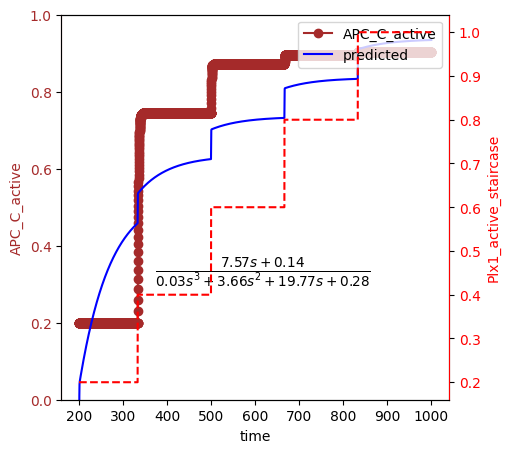

In [6]:
result = CTLSB.plotTransferFunctionFit(fit_start_time=200, final_value=1.0, ylim=[0, 1])

In [34]:
# Calculates the R-square estimated from the data
def calculateRsq(timeseries):
    out_arr = timeseries[CTLSB.output_name].values
    var = np.var(out_arr)
    mse = np.mean((out_arr - timeseries["predicted"])**2)
    rsq = 1 - mse/var
    return np.round(rsq, 2)

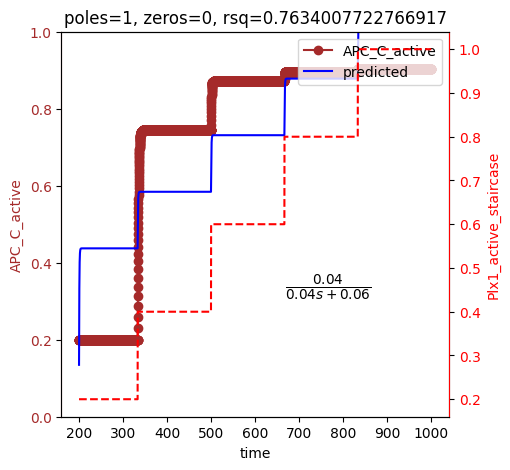

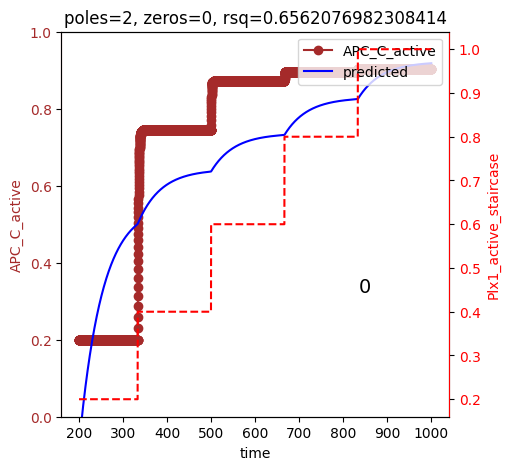

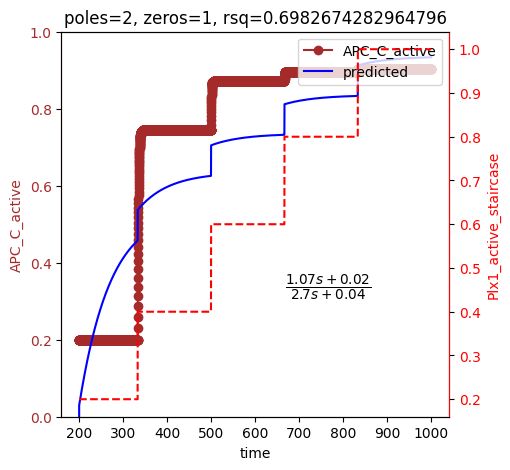

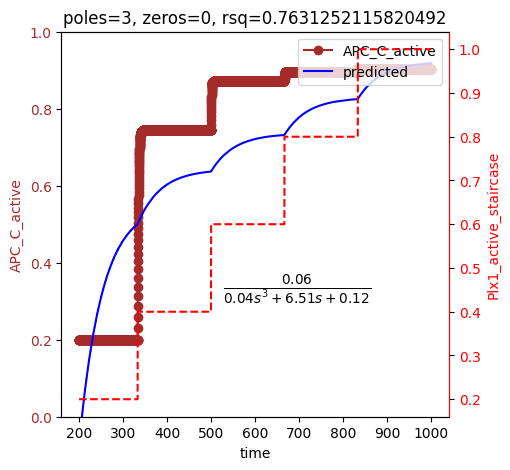

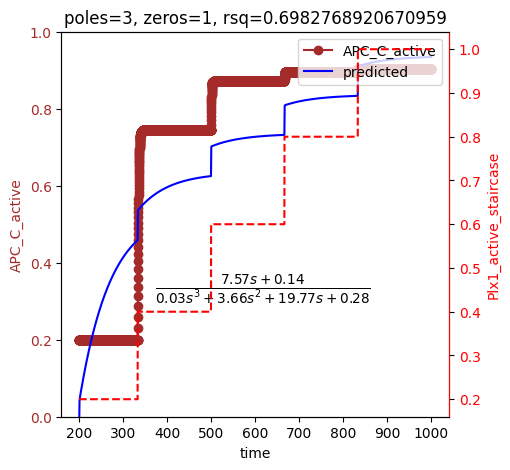

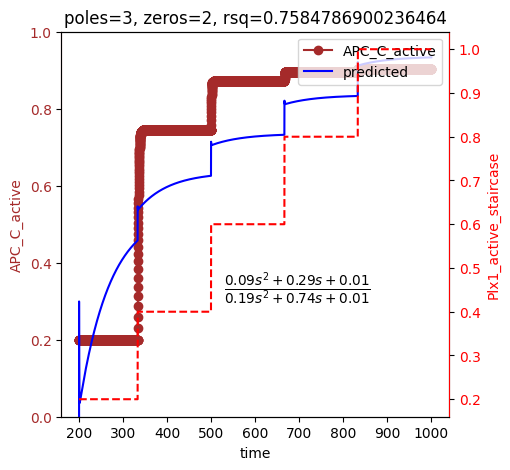

In [33]:
for num_pole in range(4):
    for num_zero in range(num_pole):
        rsq = calculateRsq(result.timeseries)
        title = "poles={num_pole}, zeros={num_zero}, rsq={rsq}".format(num_pole=num_pole, num_zero=num_zero, rsq=rsq)
        result = CTLSB.plotTransferFunctionFit(num_zero=num_zero, num_pole=num_pole, fit_start_time=200, final_value=1.0, ylim=[0, 1],
                                              title=title)
        

In [ ]:
transfer_function = CTLSB.getOpenLoopTransferFunction()
print(transfer_function)
transfer_function.dcgain()

### Conclusion:
The three best fitting transfer functions had numerator and denominator s degrees of (1,2), (2,3), and (3,4) respectively. The maximum R^2 was around .9, which is fairly good considering the nonlinearity of the input's affect on the output (certain steps would have very large impacts on the output while others would have fairly small impacts, despite the steps all being the same size). The increase in fit quality seen with increasingly complicated trasfer functions was very minor, so I feel comfortable maximizing simplicity and estimating my transfer function to be $\frac{9.53}{10s + 5.84}$. Because of its simplicity, I will be using $\frac{9.53}{10s + 5.84}$ as the transfer function for my control design instead of the open loop transfer function found using the getOpenLoopTransferFunction() function (Which was $\frac{9.93s^2 - 0.9018s + 9.956}{9.461s^3 + 6.147s^2 + 9.579s + 6.113}$).

There is one pole in my estimated transfer function at -0.584+0.j. It is negative meaning it is stable, and it has no imaginary part so it does not oscillate. The system converges at a moderate pace (-.584 is somewhat near 0, closer to zero would mean slower convergence).

The DC gain of the system is 1.632, meaning that according to the transfer function, the system output will change by a value of 1.632 for every change of 1 in the input.

Without knowledge of how the values of the estimated transfer function correspond to constants in the antimony model, I am not sure how I can estimate how to change the parameters of the system to adjust the dynamics. I assume increasing parameters like k_apc_on that affect activation rate of my output might move the actual APC_C_active cloaser to the predicted lines (and closer to the Plx1_active_staircase).

# Testbed Construction and Control Design

We begin with a simple proportional controller with the setpoint of 0.5.

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.95s/it]


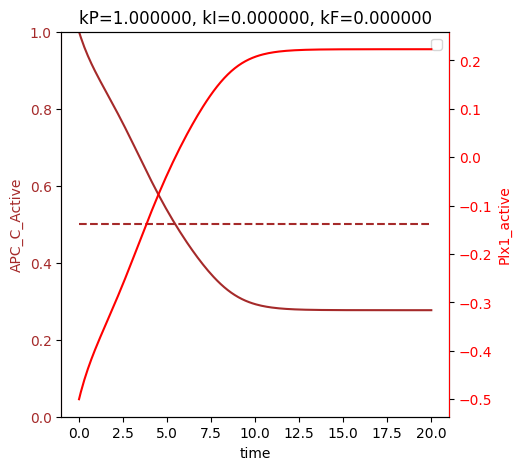

In [44]:
_ = CTLSB.plotDesign(setpoint=0.5, kP_spec=1, kI_spec=0, ylabel="APC_C_Active",
                    ylim=[0,1], times=np.linspace(0, 20, 200))

Clearly, refinements are required to regulate to the desired setpoint.

I plotted the above plot with many different values of kP and kI. The parameters found above were the ones that I think (from visual inspection) best aligned APC_C_active with the setpoint of .25. When searching the parameter space, I chose values completely randomly and had no intuition as to how changing kP or kI would affect the fit. While I visually think this fit looks pretty good, I think I got fairly lucky and I do not have a quantitative measure showing this was the best fit I saw during my random parameter search.

In [ ]:
_ = plotModel(cl_model, selections=["setpoint", INPUT_NAME, OUTPUT_NAME],
              setpoint=.75, kP=.1, kI=0.01, times=np.linspace(0, 2000, 20000), title="System under PI control, setpoint .75")

I also manually searched the parameter space when the setpoint was set to .75. Visually, I think the values I used for kP and kI when fitting to the .25 setpoint also look best for the .75 setpoint. I am interested to see whether that holds true when I search the parameter space more systematically.

## Root Locus Analysis

### Prportional Control

In [48]:
TRANSFER_FUNCTION = CTLSB.getOpenLoopTransferFunction()

In [49]:
TRANSFER_FUNCTION.poles()

array([-1.73808807e+02+0.j, -3.90319548e+00+0.j, -1.42107059e-02+0.j])

In [50]:
TRANSFER_FUNCTION.zeros()

array([-3.23104316+0.j, -0.01801705+0.j])

There is one open-loop pole. It has a real component at -.584 and no imaginary component.

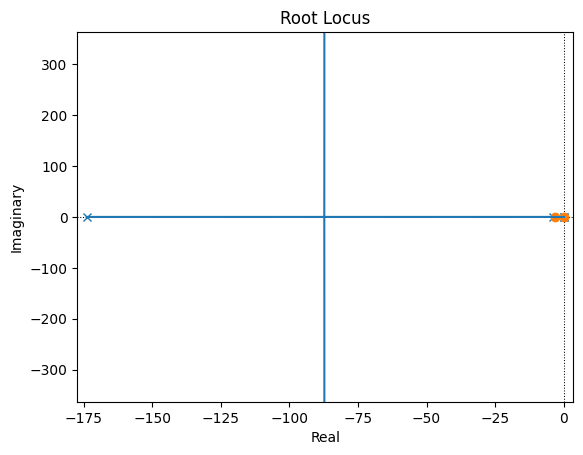

In [47]:
s = control.TransferFunction.s
_ = control.root_locus(CTLSB.getOpenLoopTransferFunction()/s, grid=False)

There is one closed loop pole and it is negative and always real. Thus when using only proportional control, increasing the value of kP will never cause the system to become unstable or to oscillate. Increasing kP will move the pole farther from zero, thus increasing kP will reduce settling time. The value of the closed loop pole starts at the value of the open loop pole at -0.584 and decreases in value as kP is increased.

### Integral Control

In [ ]:
(ctlsb_CO1_tf/s).poles()

There are two open loop poles. Both only have real components. One is at -0.584 (the same value as the only pole in proportional control) and the other is at 0.

In [ ]:
_ = control.root_locus(ctlsb_CO1_tf/s, grid=False)

When using integral control, there are two closed loop poles. They each starts at one of the open loop poles. They each remain real while geting closer to a value around -.29. Once reaching about -.29, there is a breakaway point where each pole has an imaginary component. Before the breakaway point the dominant pole is the one that began at 0. After the breakaway point each pole is equidistant to zero. All pole values are always negative, so this system will not become unstable as kI increases, but it can become oscillatory as kI increases.

The values of the closed loop poles are always negative, so when using integral control the system is always stable. However, at kI values that push the poles past the breakaway point, the system's behavior will become oscillatory. My goal in my control system will be to set kI values that bring the closed loop poles as close to the breakaway point as possible without passing it, thus maximizing my dominant pole's distance from zero (minimizing my system's settling time) while disallowing oscillation in the system.

**Conclusion**: When exploring kP and kI, I will explore higher values of kP than values of kI. Doing so will hopefully find parameter values that yield a non-oscilatory system with a rapid settling time.

### Grid Search

My two control objective involve holding APC_C_active at two different setpoints; .25 to expetide cell cycle progression, and .75 to slow cell cycle progression. Thus I will conduct two grid searches, optimizing parameters once for a system intended to hold APC_C_active at .25 and once for a system intended to hold APC_C_active at .75.

100%|██████████| 100/100 [00:18<00:00,  5.44it/s]


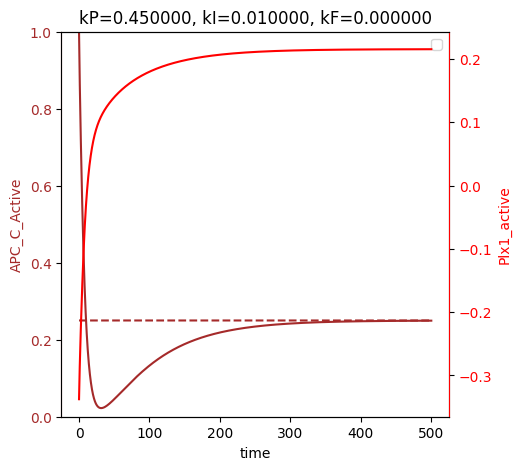

In [57]:
result = CTLSB.plotDesign(setpoint=0.25, kP_spec=True, kI_spec=True, ylabel="APC_C_Active",
                    ylim=[0,1], times=np.linspace(0, 500, 5000),
                    min_parameter_value=0.01, max_parameter_value=1,
                    num_coordinate=10)

In [58]:
result.designs.dataframe

,score,kI,reason,kP
0,0.009635,0.01,Design successful.,0.45
1,0.009804,0.01,Design successful.,0.56
2,0.009981,0.01,Design successful.,0.34
3,0.010560,0.01,Design successful.,0.23
4,0.011251,0.01,Design successful.,0.12
...,...,...,...,...
95,0.434552,0.89,Design successful.,0.89
96,0.434553,0.78,Design successful.,1.00
97,0.434554,1.00,Design successful.,0.89
98,0.434555,0.89,Design successful.,1.00


### Discussion

Below are some challenges I faced during the control design process:

**Deciding between transfer tunctions**: I didn't feel that any of the transfer functions I estimated represented my system very well due to the nonlinear relationship between my system's inputs and outputs. As such, I didn't have much intuition guiding my decision of which transfer function I should use for the downstream design. I tried to address this by writing a function that calculated the R^2 of each transfer function's fit, but the R^2 values ended up being fairly similar. Ultimately I decided to move forward with the simplest transfer function I felt I could justify. I used this strategy because it simplified my root locus plots and I hoped it would help me have a clearer understanding of how changes in kP and kI would affect the system dynamics when using PI control. I think this was an alright strategy.

**Interpreting root locus plots**: Honestly I just found root locus plots pretty complicated in general. I tried to do some googling to understand them more deeply but it looked like online many root locus plot analyses are done varying the gain and looking at the resulting impacts on the poles while our root locus plots were varying kP and kI. The tools I felt were most helpful in navigating this challenge was rereading the jupiter notebook on root locus plots and paying attention in class to our discussions interpreting root locus plots.

**Choosing what ranges to search for parameter estimation**: At the time I coded my grid search, I did not have much intuition for what search space I should be searching for each parameter. I overcame this by trying a bunch of different ranges and keeping the ranges that yielded the models with the best rmse.

**Dealing with the initial transience in my system**: The initial transient behavior of my system plagued me throughout this project. Indexing it away (indexing into the data to remove the data points during the transience) helped me ignore it to get better R^2 values when fitting my transfer function and estimating control parameters. I find it ultimately very unsatisfying that none of the control designs I found would be possible in a real chemical system. The requirement that my input values be negative during the initial transience is very frustrating.

This was a fun project! Thank you for a great class!